# Enrollment Prediction - Binary Logit

### Goals

* Identify the effect of scholarship amounts on a student's decision to enroll at the UW or not
* Use the original approach of HCRC; a binary logistic regression. 

### Process

* A. Load in data and software libraries
* B. Set the option flags for this run
* C. Visualize the different factors and how they interact
* D. Normalize, clean up, and dummy-code various factors
* E. Split into training and test sets
* F. Run a binary logistic regression
* G. Evaluate the results for accuracy
* H. Save off the model for use elsewhere

### Resources

* http://blog.yhat.com/posts/logistic-regression-python-rodeo.html 
* http://machinelearningmastery.com/logistic-regression-tutorial-for-machine-learning/
* http://www.dataschool.io/logistic-regression-in-python-using-scikit-learn/
* https://www.r-bloggers.com/how-to-perform-a-logistic-regression-in-r/

## Part A: Load in data and software libraries

**Load in the software libraries**

In [1]:
# Load in software libraries
import os
import sys
import pandas as pd
import numpy as np
import pickle

# Get data-munging libraries
from sklearn import preprocessing
from sklearn.preprocessing import Binarizer, FunctionTransformer
from sklearn import decomposition

# Get ML libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import Nystroem
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.pipeline import make_pipeline, make_union

import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.cross_validation import train_test_split


#from tpot import TPOTClassifier

## Get propensity score libraries
from causalinference import CausalModel

# Get Viz libraries
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\laulck\AppData\Local\Continuum\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\laulck\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


**Load in the data**

In [2]:
#df = pd.read_csv('Working_Data_set.csv')
#df = pd.read_csv('working_data_set_v2.csv.zip', compression='infer')
df = pd.read_csv('working_data_set_Lavi.csv', delimiter = '\t')
retention_df = pd.read_csv('retention_info.csv')

In [3]:
df.head()

system_key    yr GenderDesc   EthnicityDesc  HighestParentalEducation  \
0     1273792  2010          F       Caucasian                         6   
1     1273792  2010          F       Caucasian                         6   
2      906897  2010          F       Caucasian                         0   
3     1248500  2010          F       Caucasian                         4   
4     1276909  2010          M  Asian American                         6   

   PurpleAndGoldAmount  EnrollYrQtr  FirstYrGPA  FirstYrCredits  \
0                    0      20114.0        0.00             0.0   
1                    0      20114.0        0.00             0.0   
2                    0      20102.0        2.57           132.0   
3                    0          NaN         NaN             NaN   
4                    0      20104.0        1.70            12.0   

   IsEnrolledOrMatriculated            ...             IntlStudies  Math  \
0                         1            ...                     NaN   NaN   
1                         1            ...                     NaN   NaN   
2                         1            ...                     NaN   NaN   
3                         0            ...                     1.0   NaN   
4                         1            ...                     NaN   NaN   

   PhysicsAstr  Environ  Law  ArtDesign  DeltaParentEdMinusAcademic  \
0          NaN      NaN  NaN        NaN                         NaN   
1          NaN      NaN  NaN        NaN                         NaN   
2          NaN      NaN  NaN        NaN                         NaN   
3          NaN      NaN  NaN        NaN                         NaN   
4          NaN      NaN  NaN        NaN                         NaN   

   DeltaAcademicMinusParentEd  DeltaIncomeMinusAcademic  \
0                         NaN                       NaN   
1                         NaN                       NaN   
2                         NaN                       NaN   
3                         NaN                       NaN   
4                         NaN                       NaN   

   DeltaAcademicMinusIncome  
0                       NaN  
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN  

[5 rows x 66 columns]

In [4]:
# Drop unneeded columns
df.drop('system_key', axis=1, inplace=True)
df.drop('GenderDesc', axis=1, inplace=True)
df.drop('EthnicityDesc', axis=1, inplace=True)
df.drop('HighSchoolCode', axis=1, inplace=True)

# Drop confounding columns
df.drop('EnrollYrQtr', axis=1, inplace=True)
df.drop('FirstYrGPA', axis=1, inplace=True)
df.drop('FirstYrCredits', axis=1, inplace=True)
df.drop('TestDesc', axis=1, inplace=True)
#df.drop('TotalBudgetRemaining', axis=1, inplace=True)
#df.drop('TuitionRemaining', axis=1, inplace=True)
#df.drop('Fisap_Income', axis=1, inplace=True)

# Dubious origin state
df.drop('OriginState', axis=1, inplace=True)

In [5]:
#not done in Dev's - fill in null values across major intent with 0s
majorIntentCols = ['BioAndMed', u'CompSci', u'Eng', u'Business', u'PsychAnthro',
       u'Nursing', u'Com', u'English', u'IntlStudies', u'Math', u'PhysicsAstr',
       u'Environ', u'Law', u'ArtDesign']

df[majorIntentCols] = df[majorIntentCols].fillna(0)

In [6]:
# Look at the columns in the data
df.columns

Index([u'yr', u'HighestParentalEducation', u'PurpleAndGoldAmount',
       u'IsEnrolledOrMatriculated', u'EFC', u'Fisap_Income',
       u'Grants_and_Scholarships', u'UW_Grants', u'WorkLoans', u'Tuition',
       u'TotalBudget', u'TuitionRemaining', u'TotalBudgetRemaining',
       u'HighSchoolGPA', u'TestScore', u'AcademicScore', u'AcademicRank',
       u'HolisticScore1', u'HolisticScore2', u'FinAidSegment',
       u'AcademicSegment', u'UWAttraction_TotalCount',
       u'UWAttraction_TotalPct', u'UWAttraction_ProdPct',
       u'UWLocationAttraction_TotalCount', u'UWLocationAttraction_TotalPct',
       u'UWEdGoals_TotalCount', u'UWEdGoals_TotalPct', u'UWEdGoals_ProdPct',
       u'LowerIncomePct', u'LowerIncomeCount', u'HigherIncomeCount',
       u'LowerParentEdPct', u'LowerParentEdCount', u'HigherParentEdCount',
       u'CollegeLocationPct_BorderState', u'FamilyIncomePct_140to200K',
       u'FirstGenerationPct_Not1stGen', u'ParentEducationPct_NoResponse',
       u'BioAndMed', u'CompSci', u

In [7]:
oldCols = ['yr', 'HighestParentalEducation', 'PurpleAndGoldAmount',
       'IsEnrolledOrMatriculated', 'EFC', 'Fisap_Income',
       'Grants_and_Scholarships', 'UW_Grants', 'WorkLoans', 'Tuition',
       'TotalBudget', 'TuitionRemaining', 'TotalBudgetRemaining',
       'HighSchoolGPA', 'TestScore', 'AcademicScore', 'AcademicRank',
       'HolisticScore1', 'HolisticScore2', 'FinAidSegment', 'AcademicSegment',
       'UWAttraction_TotalCount', 'UWAttraction_TotalPct',
       'UWAttraction_ProdPct', 'UWLocationAttraction_TotalCount',
       'UWLocationAttraction_TotalPct', 'UWEdGoals_TotalCount',
       'UWEdGoals_TotalPct', 'UWEdGoals_ProdPct', 'LowerIncomePct',
       'LowerIncomeCount', 'HigherIncomeCount', 'LowerParentEdPct',
       'LowerParentEdCount', 'HigherParentEdCount',
       'CollegeLocationPct_BorderState', 'FamilyIncomePct_140to200K',
       'FirstGenerationPct_Not1stGen', 'ParentEducationPct_NoResponse',
       'BioAndMed', 'CompSci', 'Eng', 'Business', 'PsychAnthro', 'Nursing',
       'Com', 'English', 'IntlStudies', 'Math', 'PhysicsAstr', 'Environ',
       'Law', 'ArtDesign', 'DeltaParentEdMinusAcademic',
       'DeltaAcademicMinusParentEd', 'DeltaIncomeMinusAcademic',
       'DeltaAcademicMinusIncome']

oldCols == list(df.columns) #double checking to see if the columns are the same across new and old datasets

True

In [8]:
df.EFC.describe()

count     56172.000000
mean      43073.774265
std       71548.493809
min           0.000000
25%        3412.500000
50%       22994.500000
75%       56332.750000
max      999999.000000
Name: EFC, dtype: float64

## Part B - Set the option flags for this run

In [9]:
# Which years are around?
np.unique(df['yr'])

array([2010, 2011, 2012, 2013, 2014, 2015, 2016], dtype=int64)

### Set All The Flags

1. Set the year
2. Set the number of interaction terms to use
3. Visualize or not
4. Normalize or not
5. Simple or detailed accuracy metrics

In [10]:
use_all_years = True
year = 2015

use_pugo_amounts = False

show_viz = False

normalize_metrics = False

detailed_accuracy_metrics = True

f_score_analysis = False

save_results = True

run_tpot = False

stratify_split = True

model_choice = 'boosting' # options are 'boosting' and 'logit'

#### Remove entries with missing data. 

In [11]:
if use_all_years == False:
    df = df.loc[df['yr'] == year]

df.drop('yr', axis=1, inplace=True)
df = df.reset_index(drop=True)

df = df[np.isfinite(df['EFC'])]

df.isnull().sum()
#this is where it showed that many major intent entries were null. This is fixed above with nulls replaced by 0s

HighestParentalEducation               0
PurpleAndGoldAmount                    0
IsEnrolledOrMatriculated               0
EFC                                    0
Fisap_Income                           0
Grants_and_Scholarships                0
UW_Grants                              0
WorkLoans                              0
Tuition                                0
TotalBudget                            0
TuitionRemaining                       0
TotalBudgetRemaining                   0
HighSchoolGPA                          0
TestScore                              0
AcademicScore                          0
AcademicRank                           0
HolisticScore1                         0
HolisticScore2                         0
FinAidSegment                          0
AcademicSegment                        0
UWAttraction_TotalCount            10345
UWAttraction_TotalPct              10345
UWAttraction_ProdPct               10345
UWLocationAttraction_TotalCount    10344
UWLocationAttrac

In [12]:
check = df[df.UWAttraction_TotalCount.isnull()]
check.HighSchoolCode.value_counts()

AttributeError: 'DataFrame' object has no attribute 'HighSchoolCode'

## Part C - Derived Features

### Part C1 - Create derived features (feature engineering)

* need_after_grants = total budgets minus grants
* need_after_grantsandincome = total budgets minus grants minus efc
* the amount a student would spend after all grants / scholarships

In [13]:
#df['need_after_grants'] = df['TotalBudget'] - df['UW_Grants'] - df['Grants_and_Scholarships']
#df['need_after_grants_efc'] = df['TotalBudget'] - df['UW_Grants'] - df['Grants_and_Scholarships'] - df['EFC']
if use_pugo_amounts:
    df['tuition_after_grants'] = df['Tuition'] - df['PurpleAndGoldAmount'] - df['Grants_and_Scholarships']
else:
    df['tuition_after_grants'] = df['Tuition'] - df['Grants_and_Scholarships']
#df['tuition_after_grants_efc'] = df['Tuition'] - df['UW_Grants'] - df['Grants_and_Scholarships'] - df['EFC']

df.ix[df.tuition_after_grants < 0, 'tuition_after_grants'] = 0

df.drop('TotalBudget', axis=1, inplace=True)
df.drop('Tuition', axis=1, inplace=True)
df.drop('UW_Grants', axis=1, inplace=True)
df.drop('Grants_and_Scholarships', axis=1, inplace=True)
df.drop('AcademicRank', axis=1, inplace=True)
df.drop('PurpleAndGoldAmount', axis=1, inplace=True)

C:\Users\laulck\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  if __name__ == '__main__':


### Part C2 - Add retention info (feature engineering)

* 5-year graduation rate
* avg quarters to graduate
* avg+1 stdev quarters to graduate
* avg-1 stdev quarters to graduate

In [14]:
retention_df['5yr_grad_rate'] = retention_df['graduated_student_count'] * 1.0 / retention_df['student_count']

In [15]:
retention_df['avgplus1_quarters_to_graduate'] = retention_df['avg_quarters_to_graduate'] + retention_df['stdev_quarters_to_graduate']
retention_df['avgminus1_quarters_to_graduate'] = retention_df['avg_quarters_to_graduate'] - retention_df['stdev_quarters_to_graduate']
retention_df.ix[retention_df.avgminus1_quarters_to_graduate < 0, 'avgminus1_quarters_to_graduate'] = 0

C:\Users\laulck\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
retention_df.drop('graduated_student_count', axis=1, inplace=True)
retention_df.drop('student_count', axis=1, inplace=True)
retention_df.drop('stdev_quarters_to_graduate', axis=1, inplace=True)

In [17]:
#retention_df[~retention_df.applymap(np.isreal).all(1)]

In [18]:
#retention_df.first_major_category.unique()

In [19]:
df['first_major_category'] = 'Unknown'
df.ix[df.BioAndMed == 1, 'first_major_category'] = 'BioAndMed'
df.ix[df.CompSci == 1, 'first_major_category'] = 'CompSci'
df.ix[df.Business == 1, 'first_major_category'] = 'Business'
df.ix[df.Eng == 1, 'first_major_category'] = 'Eng'
df.ix[df.PsychAnthro == 1, 'first_major_category'] = 'PsychAnthro'
df.ix[df.ArtDesign == 1, 'first_major_category'] = 'ArtDesign'
df.ix[df.Law == 1, 'first_major_category'] = 'Com, PoliSci, Law, IntlStudies'
df.ix[df.IntlStudies == 1, 'first_major_category'] = 'Com, PoliSci, Law, IntlStudies'
df.ix[df.Nursing == 1, 'first_major_category'] = 'Nursing'
df.ix[df.Com == 1, 'first_major_category'] = 'Com, PoliSci, Law, IntlStudies'
df.ix[df.Math == 1, 'first_major_category'] = 'MathAndScience'
df.ix[df.PhysicsAstr == 1, 'first_major_category'] = 'MathAndScience'
df.ix[df.Environ == 1, 'first_major_category'] = 'MathAndScience'
df.ix[df.English == 1, 'first_major_category'] = 'Com, PoliSci, Law, IntlStudies'

In [20]:
df['LowerHighSchoolGPA'] = 0
df.ix[df.HighSchoolGPA > 3.0, 'LowerHighSchoolGPA'] = 3
df.ix[df.HighSchoolGPA > 3.4, 'LowerHighSchoolGPA'] = 3.4
df.ix[df.HighSchoolGPA > 3.6, 'LowerHighSchoolGPA'] = 3.6
df.ix[df.HighSchoolGPA > 3.8, 'LowerHighSchoolGPA'] = 3.8

In [21]:
df['UpperHighSchoolGPA'] = 3
df.ix[df.HighSchoolGPA > 3, 'UpperHighSchoolGPA'] = 3.4
df.ix[df.HighSchoolGPA > 3.4, 'UpperHighSchoolGPA'] = 3.6
df.ix[df.HighSchoolGPA > 3.6, 'UpperHighSchoolGPA'] = 3.8
df.ix[df.HighSchoolGPA > 3.8, 'UpperHighSchoolGPA'] = 4.0

In [22]:
#df.first_major_category.unique()

In [23]:
dfr = df.merge(retention_df, how='left', on=['first_major_category','LowerHighSchoolGPA','UpperHighSchoolGPA'])

In [24]:
dfr.drop('first_major_category', axis=1, inplace=True)

In [25]:
list(dfr.columns)

['HighestParentalEducation',
 'IsEnrolledOrMatriculated',
 'EFC',
 'Fisap_Income',
 'WorkLoans',
 'TuitionRemaining',
 'TotalBudgetRemaining',
 'HighSchoolGPA',
 'TestScore',
 'AcademicScore',
 'HolisticScore1',
 'HolisticScore2',
 'FinAidSegment',
 'AcademicSegment',
 'UWAttraction_TotalCount',
 'UWAttraction_TotalPct',
 'UWAttraction_ProdPct',
 'UWLocationAttraction_TotalCount',
 'UWLocationAttraction_TotalPct',
 'UWEdGoals_TotalCount',
 'UWEdGoals_TotalPct',
 'UWEdGoals_ProdPct',
 'LowerIncomePct',
 'LowerIncomeCount',
 'HigherIncomeCount',
 'LowerParentEdPct',
 'LowerParentEdCount',
 'HigherParentEdCount',
 'CollegeLocationPct_BorderState',
 'FamilyIncomePct_140to200K',
 'FirstGenerationPct_Not1stGen',
 'ParentEducationPct_NoResponse',
 'BioAndMed',
 'CompSci',
 'Eng',
 'Business',
 'PsychAnthro',
 'Nursing',
 'Com',
 'English',
 'IntlStudies',
 'Math',
 'PhysicsAstr',
 'Environ',
 'Law',
 'ArtDesign',
 'DeltaParentEdMinusAcademic',
 'DeltaAcademicMinusParentEd',
 'DeltaIncomeMinus

In [26]:
#dfr['avg_quarters_to_graduate'].describe()

In [27]:
#dfr[pd.isnull(dfr['avg_quarters_to_graduate'])]

In [28]:
#dfr.first_major_category.head()

In [29]:
%matplotlib inline

## Part D - Normalize, clean up, and dummy-code various factors

1. Convert Categorical Features to binary ones (dummy coding)
2. Create more derived features (feature engineering)
3. Normalize everything

### Part D3 - Normalize everything

* http://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/

**Option Flags**

If 'normalize_metrics' is set, then we normalize all the features using standard scaling. Otherwise we leave them alone.

In [30]:
finaiddummy_df = pd.get_dummies(dfr['FinAidSegment'], prefix='finaid')
acaddummy_df = pd.get_dummies(dfr['AcademicSegment'], prefix='acad')
eddummy_df = pd.get_dummies(dfr['HighestParentalEducation'], prefix='ed')

eddummy_df['ed_1m'] = eddummy_df['ed_1']+eddummy_df['ed_2']+eddummy_df['ed_3']+eddummy_df['ed_4']+eddummy_df['ed_5']+eddummy_df['ed_6']
eddummy_df['ed_2m'] = eddummy_df['ed_2']+eddummy_df['ed_3']+eddummy_df['ed_4']+eddummy_df['ed_5']+eddummy_df['ed_6']
eddummy_df['ed_3m'] = eddummy_df['ed_3']+eddummy_df['ed_4']+eddummy_df['ed_5']+eddummy_df['ed_6']
eddummy_df['ed_4m'] = eddummy_df['ed_4']+eddummy_df['ed_5']+eddummy_df['ed_6']
eddummy_df['ed_5m'] = eddummy_df['ed_5']+eddummy_df['ed_6']

# Investigate fin aid dummy variables
# finaiddummy_df.head()

# Investigate academic dummy variables
# acaddummy_df.head()

# Join the binary variables to the data
df_1 = dfr.join(eddummy_df)
df_2 = df_1.join(finaiddummy_df)
df_3 = df_2.join(acaddummy_df)

df_3.drop('FinAidSegment', axis=1, inplace=True)
df_3.drop('AcademicSegment', axis=1, inplace=True)
df_3.drop('HighestParentalEducation', axis=1, inplace=True)

df_3 = df_3.reset_index(drop=True)

#df_3.head()

In [31]:
df_IsEnrolled = df_3.IsEnrolledOrMatriculated.copy()

if detailed_accuracy_metrics:
    print ('df_IsEnrolled has',df_IsEnrolled.count(),'records, and', df_IsEnrolled.sum(),'are enrolled')
    print ('df3 has',df_3.TestScore.count(),' records')

('df_IsEnrolled has', 56172, 'records, and', 8576L, 'are enrolled')
('df3 has', 56172, ' records')


In [32]:
if normalize_metrics:
    scaler = preprocessing.StandardScaler().fit(df_3)
    # print out the scales so we can use them in the optimization
    print (np.column_stack((df_3.columns, np.transpose(scaler.scale_))))
    #save off the column names
    df_3_columns = df_3.columns 
    df_4 = pd.DataFrame(scaler.transform(df_3))
    df_4.columns = df_3_columns #re-assign the column names
    # Re-add is enrolled or matriculated to convert it back to an int
    df_4.drop('IsEnrolledOrMatriculated', axis=1, inplace=True)
    df_5 = pd.DataFrame(df_IsEnrolled).join(df_4)
    #print 'df_4 has ',df_4.count(),' records'
else: 
    # Use this to skip the scaling step
    df_5 = df_3.copy()

## Part E - Split into training and test sets

1. Come up with interaction terms
2. Use a 70-30 split

### Part E1 - Come up with interaction terms 

**Use PolynomialFeatures**

* Very useful - http://stackoverflow.com/questions/33257199/how-to-generate-many-interaction-terms-in-pandas
* Reference - http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html



* Complicated - http://www.dummies.com/programming/big-data/data-science/data-science-how-to-create-interactions-between-variables-with-python/
* http://patsy.readthedocs.io/en/latest/
* http://stats.idre.ucla.edu/stata/seminars/deciphering-interactions-in-logistic-regression/
* https://www.datarobot.com/blog/multiple-regression-using-statsmodels/
* http://stackoverflow.com/questions/33050104/difference-between-the-interaction-and-term-for-formulas-in-statsmodels-ols

**Option Flags**

if 'full_interaction_terms' is set, then we use *all* interaction terms. Otherwise we limit ourselves to the ones only found useful when running the model in the past.

In [33]:
# Create the X and Y variables
y = df_5.IsEnrolledOrMatriculated
x = df_5.copy()

x.drop('IsEnrolledOrMatriculated', axis=1, inplace=True)

if detailed_accuracy_metrics:
    print (x.columns)

Index([u'EFC', u'Fisap_Income', u'WorkLoans', u'TuitionRemaining',
       u'TotalBudgetRemaining', u'HighSchoolGPA', u'TestScore',
       u'AcademicScore', u'HolisticScore1', u'HolisticScore2',
       u'UWAttraction_TotalCount', u'UWAttraction_TotalPct',
       u'UWAttraction_ProdPct', u'UWLocationAttraction_TotalCount',
       u'UWLocationAttraction_TotalPct', u'UWEdGoals_TotalCount',
       u'UWEdGoals_TotalPct', u'UWEdGoals_ProdPct', u'LowerIncomePct',
       u'LowerIncomeCount', u'HigherIncomeCount', u'LowerParentEdPct',
       u'LowerParentEdCount', u'HigherParentEdCount',
       u'CollegeLocationPct_BorderState', u'FamilyIncomePct_140to200K',
       u'FirstGenerationPct_Not1stGen', u'ParentEducationPct_NoResponse',
       u'BioAndMed', u'CompSci', u'Eng', u'Business', u'PsychAnthro',
       u'Nursing', u'Com', u'English', u'IntlStudies', u'Math', u'PhysicsAstr',
       u'Environ', u'Law', u'ArtDesign', u'DeltaParentEdMinusAcademic',
       u'DeltaAcademicMinusParentEd', u'DeltaIn

### Part E2 - Split in a 70-30 split

In [36]:
#removal of null values

drop_all_nulls = True

if drop_all_nulls:
    cols = x.columns[x.isnull().any()]
    y = y[~x[cols].isnull().any(axis = 1)]
    x = x[~x[cols].isnull().any(axis = 1)]
    df_3_cleaned = df_3.loc[x.index]

In [37]:
if stratify_split == True:
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=42, stratify=y)
else:
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=42)

print ('x_train has',x_train.AcademicScore.count())
print ('y_train has',y_train.count())
print ('')
print ('x_test has',x_test.AcademicScore.count())
print ('y_test has',y_test.count())

df_train = x_train.join(y_train)

#df_train.describe()
#del x, y

('x_train has', 32078)
('y_train has', 32078)

('x_test has', 13749)
('y_test has', 13749)


## Part F - Find and run classifiers

* http://statsmodels.sourceforge.net/devel/example_formulas.html
* http://statsmodels.sourceforge.net/stable/generated/statsmodels.discrete.discrete_model.Logit.html#statsmodels.discrete.discrete_model.Logit


In [38]:
# See if there are any columns that won't run in a logit cleanly
if detailed_accuracy_metrics:
    df_train[~df_train.applymap(np.isreal).all(1)]

### Part F1 - Optionally use TPOT to do identify good classifiers

In [39]:
if run_tpot:
    tpot = TPOTClassifier(generations=4, population_size=15, verbosity=3, scoring='f1')
    tpot.fit(x_train, y_train)
    print(tpot.score(x_test, y_test))
    tpot.export('tpot_enrollment_pipeline.py')

### Part F2 - Run models manually

**Gradient Boosting**

In [40]:
if model_choice == 'boosting':
    ## gradient boosting
    clf = GradientBoostingClassifier(learning_rate=0.2, n_estimators=500, verbose=1)
    clf.fit(x_train, y_train)
    #
    probs = clf.predict_proba(x_train)
    predicts = clf.predict(x_train)
    #
    probs_test = clf.predict_proba(x_test)
    predicts_test = clf.predict(x_test)

      Iter       Train Loss   Remaining Time 
         1           0.7771           41.42s
         2           0.7560           42.58s
         3           0.7429           43.24s
         4           0.7347           43.52s
         5           0.7280           43.26s
         6           0.7231           43.88s
         7           0.7142           44.09s
         8           0.7078           44.28s
         9           0.7032           44.84s
        10           0.7006           44.39s
        20           0.6784           42.89s
        30           0.6674           41.85s
        40           0.6581           40.32s
        50           0.6505           39.38s
        60           0.6451           37.99s
        70           0.6404           36.87s
        80           0.6351           35.95s
        90           0.6306           34.62s
       100           0.6264           33.67s
       200           0.5866           25.15s
       300           0.5539           16.92s
       40

In [41]:
if model_choice == 'boostingv2':
    #tpot_data = np.recfromcsv('PATH/TO/DATA/FILE', delimiter='COLUMN_SEPARATOR', dtype=np.float64)
    #features = np.delete(tpot_data.view(np.float64).reshape(tpot_data.size, -1), tpot_data.dtype.names.index('class'), axis=1)
    #training_features, testing_features, training_classes, testing_classes = \
    #train_test_split(features, tpot_data['class'], random_state=42)
    #
    clf = make_pipeline(
        make_union(VotingClassifier([("est", GradientBoostingClassifier(learning_rate=0.2, max_features=None, n_estimators=500))]), FunctionTransformer(lambda X: X)),
        #Nystroem(gamma=0.66, kernel="poly", n_components=49),
        Binarizer(threshold=49.0),
        GaussianNB()
    )
    #
    clf.fit(x_train, y_train)
    probs = clf.predict_proba(x_train)
    predicts = clf.predict(x_train)
    #
    probs_test = exported_pipeline.predict_proba(x_test)
    predicts_test = exported_pipeline.predict(x_test)

In [42]:
#dir(clf)

In [43]:
#if model_choice == 'boosting':
fi = enumerate(clf.feature_importances_)
cols = x_train.columns
sorted([(value*100, cols[i]) for (i,value) in fi if value > 0.001], reverse=True)

[(6.1618374061559154, 'Fisap_Income'),
 (4.9881423296969398, 'AcademicScore'),
 (4.775186490136087, 'EFC'),
 (4.0622480332890838, 'UWLocationAttraction_TotalPct'),
 (3.3669171421027522, 'DeltaAcademicMinusParentEd'),
 (3.349484135895227, 'TestScore'),
 (3.2932340049861391, 'LowerIncomePct'),
 (3.2182587399209832, 'HigherIncomeCount'),
 (3.1159483642580348, 'ParentEducationPct_NoResponse'),
 (3.0602676526446855, 'DeltaParentEdMinusAcademic'),
 (2.9994572892156195, 'LowerParentEdPct'),
 (2.7849248703366145, 'FirstGenerationPct_Not1stGen'),
 (2.7788881967898211, 'CollegeLocationPct_BorderState'),
 (2.7213791011237243, 'DeltaIncomeMinusAcademic'),
 (2.6429714275514899, 'UWAttraction_TotalPct'),
 (2.4637401166504485, 'UWAttraction_ProdPct'),
 (2.427698766549037, 'DeltaAcademicMinusIncome'),
 (2.4163481068669999, 'UWLocationAttraction_TotalCount'),
 (2.3918210368407777, 'LowerParentEdCount'),
 (2.2238814800839091, 'UWEdGoals_TotalCount'),
 (1.9911974340966052, 'LowerIncomeCount'),
 (1.970452

**Logistic** (just for reference)

## Part G - Evaluate the results for accuracy

1. Look at the logit accuracy scores
2. Look at the ROC/AUC scores
3. Look at the initial confusion matrix
4. Optimize for F scores
5. Look at feature importance


**Good Resources**

* https://github.com/justmarkham/DAT4/blob/master/notebooks/08_linear_regression.ipynb
* http://blog.yhat.com/posts/logistic-regression-and-python.html

### Part G1 - look at the accuracy scores lift

In [44]:
if detailed_accuracy_metrics:
    print ('Baseline training accuracy is', 1.0-y_train.mean())
    # Baseline accuracy is 85.48%
    print ('Training score for',model_choice,'is', clf.score(x_train, y_train))
    # 0.75451707501655474 after class_weight = 'balanced. A bad idea
    # BAD IDEA - 0.88080597862075494 use 'sag' solver. Don't do that
    print ('Improvement above the training baseline is',(clf.score(x_train, y_train)) - (1.0-y_train.mean()))
    print ('Percent improvement above the training baseline is',((clf.score(x_train, y_train)) - (1.0-y_train.mean())) / y_train.mean())

('Baseline training accuracy is', 0.8582205873184113)
('Training score for', 'boosting', 'is', 0.90738200635949873)
('Improvement above the training baseline is', 0.049161419041087395)
('Percent improvement above the training baseline is', 0.3467458223394902)


In [45]:
# Baseline accuracy
print ('Baseline test accuracy is', 1.0-y_test.mean())
# Baseline accuracy is 85.48%

print ('Test score for',model_choice,'is', clf.score(x_test, y_test))

print ('Improvement above the test baseline is',(clf.score(x_test, y_test)) - (1.0-y_test.mean()))
print ('Percent improvement above the test baseline is',((clf.score(x_test, y_test)) - (1.0-y_test.mean())) / y_test.mean())

('Baseline test accuracy is', 0.8582442359444323)
('Test score for', 'boosting', 'is', 0.87293621354280315)
('Improvement above the test baseline is', 0.01469197759837082)
('Percent improvement above the test baseline is', 0.10364289379168826)


### Part G2 - Look at the ROC/AUC scores

In [46]:
if detailed_accuracy_metrics:
    # generate evaluation metrics
    print ('Training Set AUC:',metrics.roc_auc_score(y_train, probs[:, 1]))

('Training Set AUC:', 0.90796920669575776)


In [47]:
# generate evaluation metrics
print ('Test Set AUC:',metrics.roc_auc_score(y_test, probs_test[:, 1]))

('Test Set AUC:', 0.77407853658112358)


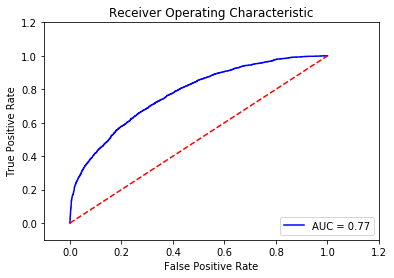

In [48]:
# Compute the FPR, TPR
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, probs_test[:, 1])
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

# Plot an ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Part G3 - Look at the initial confusion matrix

In [49]:
y_array = np.array(y_train)
confusion_output = metrics.confusion_matrix(y_array, predicts)
#print (confusion_output)
true_positive = confusion_output[1][0] # student enrolled and we predicted they would enroll
false_positive = confusion_output[1][1] # student enrolled and we predicted they wouldn't enroll
true_negative = confusion_output[0][0] # student didn't enroll and we predicted they wouldn't enroll
false_negative = confusion_output[0][1] # student didn't enroll and we predicted they would enroll 
precision = true_positive * 1.0 / (true_positive + false_positive)
recall = true_positive * 1.0 / (true_positive + false_negative)
f_score = (precision * recall * 2.0) / (precision + recall)

print ('Of the',true_positive+false_positive,'students who enrolled at the UW, we correctly predicted',true_positive,'of them')
print ('Of the',true_positive+false_negative,'students who we predicted would enroll at the UW',true_positive,'of them did')
if detailed_accuracy_metrics:
    print ('True positive',true_positive,', False Positive',false_positive)
    print ('True negative',true_negative,', False Negative',false_negative)
    print ('Precision:',precision,'Recall:', recall, 'F-Score:',f_score)

('Of the', 4548, 'students who enrolled at the UW, we correctly predicted', 2787, 'of them')
('Of the', 2971, 'students who we predicted would enroll at the UW', 2787, 'of them did')
('True positive', 2787, ', False Positive', 1761)
('True negative', 27346, ', False Negative', 184)
('Precision:', 0.61279683377308702, 'Recall:', 0.93806799057556378, 'F-Score:', 0.74132198430642371)


In [50]:
# Now do it for the TEST set
y_array = np.array(y_test)
confusion_output = metrics.confusion_matrix(y_array, predicts_test)
#print (confusion_output)
true_positive = confusion_output[1][0] # student enrolled and we predicted they would enroll
false_positive = confusion_output[1][1] # student enrolled and we predicted they wouldn't enroll
true_negative = confusion_output[0][0] # student didn't enroll and we predicted they wouldn't enroll
false_negative = confusion_output[0][1] # student didn't enroll and we predicted they would enroll 
precision = true_positive * 1.0 / (true_positive + false_positive)
recall = true_positive * 1.0 / (true_positive + false_negative)
f_score = (precision * recall * 2.0) / (precision + recall)

print ('Of the',true_positive+false_positive,'students who enrolled at the UW, we correctly predicted',true_positive,'of them')
print ('Of the',true_positive+false_negative,'students who we predicted would enroll at the UW',true_positive,'of them did')
if detailed_accuracy_metrics:
    print ('True positive',true_positive,', False Positive',false_positive)
    print ('True negative',true_negative,', False Negative',false_negative)
    print ('Precision:',precision,'Recall:', recall, 'F-Score:',f_score)

('Of the', 1949, 'students who enrolled at the UW, we correctly predicted', 1508, 'of them')
('Of the', 1747, 'students who we predicted would enroll at the UW', 1508, 'of them did')
('True positive', 1508, ', False Positive', 441)
('True negative', 11561, ', False Negative', 239)
('Precision:', 0.77373011800923552, 'Recall:', 0.86319404693760737, 'F-Score:', 0.81601731601731609)


#### Results Tracking

* Store in a Google sheet, https://docs.google.com/a/uw.edu/spreadsheets/d/1ne3dhmafyKZQNlTm7dlONYXvflGP-r3K-CeHfnOO6Qw/edit?usp=sharing 


## Part H - Propensity Score Matching

### Resources

**Highly Useful Code and Guides**

* https://stats.stackexchange.com/questions/206832/matched-pairs-in-python-propensity-score-matching
* https://www.quora.com/Where-can-I-find-a-good-writeup-about-propensity-models


**Code**
* http://nbviewer.jupyter.org/github/kellieotto/StatMoments/blob/master/PSM.ipynb
* https://github.com/laurencium/causalinference
* https://github.com/MacHu-GWU/ctmatching-project

**Documentation/Guides**
* http://laurence-wong.com/software/


### Steps
* Predict the probabilities
* Split into buckets
* Visualize the causal factor of each bucket

In [51]:
# Predict the probabilities
predictions = clf.predict_proba(x)

#sns.jointplot(x="tuition_after_grants", y="IsEnrolledOrMatriculated", data=df);

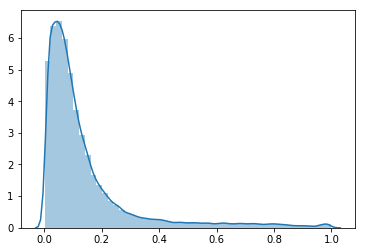

In [52]:
# Visualize the probabilities
sns.distplot(predictions[:, 1], hist=True, rug=False);

In [53]:
x.shape

(45827, 79)

In [55]:
#predict_df = df_3[['Fisap_Income', 'EFC', 'AcademicScore','DeltaAcademicMinusIncome', 'LowerIncomePct', 'DeltaParentEdMinusAcademic','IsEnrolledOrMatriculated']].copy(deep=True)
predict_df = df_3_cleaned[['Fisap_Income', 'EFC', 'AcademicScore','DeltaAcademicMinusIncome', 'LowerIncomePct', 'DeltaParentEdMinusAcademic','IsEnrolledOrMatriculated']].copy(deep=True)
predict_df['PropensityScore'] = predictions[:, 1]

In [56]:
# Split into buckets
bins = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3,0.4,0.6, 0.8, 1.0]
bin_name = [0,1,2,3,4,5,6,7,8,9]

In [57]:
predict_df['PropensityBin'] = pd.cut(predict_df['PropensityScore'], bins, labels=bin_name)

#### Use the CausalInference library
* https://github.com/laurencium/causalinference/blob/master/docs/tex/vignette.pdf

In [58]:
#causal = CausalModel(Y, D, X)
# Y 'an N-vector of observed outcomes'
# D 'an N-vector of treatment status indicators'
# X 'an N-by-K matrix of covariates'

In [59]:
d_causal = predict_df.IsEnrolledOrMatriculated
y_causal = predict_df.PropensityScore

x_causal = predict_df.copy()
x_causal.drop('PropensityScore', axis=1, inplace=True)
#x_causal.drop('PropensityBin', axis=1, inplace=True)
x_causal.drop('IsEnrolledOrMatriculated', axis=1, inplace=True)

print (x_causal.columns)

Index([u'Fisap_Income', u'EFC', u'AcademicScore', u'DeltaAcademicMinusIncome',
       u'LowerIncomePct', u'DeltaParentEdMinusAcademic', u'PropensityBin'],
      dtype='object')


In [60]:
x_causal2 = x_causal.apply(pd.to_numeric, errors='ignore')

In [61]:
[x_causal2.iloc[:,i].apply(type).value_counts() for i in range(x_causal2.shape[1])]

[<type 'float'>    45827
 Name: Fisap_Income, dtype: int64, <type 'float'>    45827
 Name: EFC, dtype: int64, <type 'float'>    45827
 Name: AcademicScore, dtype: int64, <type 'float'>    45827
 Name: DeltaAcademicMinusIncome, dtype: int64, <type 'float'>    45827
 Name: LowerIncomePct, dtype: int64, <type 'float'>    45827
 Name: DeltaParentEdMinusAcademic, dtype: int64, <type 'long'>    45827
 Name: PropensityBin, dtype: int64]

In [62]:
causal = CausalModel(y_causal, d_causal, x_causal2.as_matrix(), )

In [63]:
# Summary stats
print(causal.summary_stats)


Summary Statistics

                     Controls (N_c=39330)        Treated (N_t=6497)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.100        0.098        0.391        0.277        0.291

                     Controls (N_c=39330)        Treated (N_t=6497)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0   161992.608   199798.069   165852.739   270458.511        0.016
             X1    45576.989    74557.761    49469.077    86529.275        0.048
             X2        0.905        0.076        0.914        0.063        0.131
             X3        0.718        0.153        0.743        0.161        0.160
             X4        0.280        0.209        0.256        0.224       -0.110
      

In [64]:
# Propensity scoring
causal.est_propensity_s()
print (causal.propensity)


Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept     -7.001      0.459    -15.252      0.000     -7.901     -6.102
            X6      0.910      0.090     10.126      0.000      0.734      1.086
            X2      3.654      0.499      7.323      0.000      2.676      4.632
            X4      1.096      0.299      3.662      0.000      0.509      1.683
         X4*X4     -2.179      0.405     -5.384      0.000     -2.973     -1.386
         X6*X2     -0.400      0.094     -4.265      0.000     -0.584     -0.216
         X6*X4      0.134      0.032      4.162      0.000      0.071      0.198
         X6*X6      0.007      0.003      2.409      0.016      0.001      0.013



In [65]:
causal.propensity.keys()

['coef', 'lin', 'qua', 'loglike', 'fitted', 'se']

In [66]:
sys.setrecursionlimit(1500)

In [67]:
causal.est_via_matching()
causal.est_via_ols()
causal.est_via_weighting()
#causal.est_via_blocking()
print(causal.estimates)


Treatment Effect Estimates: Weighting

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.014      0.002     -7.583      0.000     -0.017     -0.010

Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.030      0.001    -21.850      0.000     -0.033     -0.028
           ATC     -0.049      0.002    -31.719      0.000     -0.052     -0.046
           ATT      0.081      0.002     50.601      0.000      0.078      0.084

Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.260      0.008     32.067      0.000      0.244      0.

In [68]:
dir (causal.estimates)

['__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__getitem__',
 '__hash__',
 '__init__',
 '__iter__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_dict',
 'get',
 'iteritems',
 'keys']